# Testing Cnots

In this notebook we take imperfect versions of cnot gates and see how well they would work within a `d=3`, `T=1` surface code and a `d=5`, `T=3` repetition code.

In [1]:
import numpy as np
from copy import deepcopy

from topological_codes import RepetitionCode, SurfaceCode, GraphDecoder

from qiskit import QuantumCircuit, transpile
from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer.noise.errors import depolarizing_error
from qiskit.circuit.library import CRXGate

from qiskit.quantum_info import process_fidelity

from matplotlib import pyplot as plt

The candidate cnots to be tested need to be provided as a Qiskit instruction. These can be created from forms such as unitaries, Choi matrices, Qiskit gates and Qiskit circuits.

For example, the following function creates a noisy cnot from a noisy circuit, parameterized by an error probability $\epsilon$. This can generate both coherent or incoherent forms of noise.

In [2]:
def noisy_cx(eps, coherent=True):
    if coherent:
        error = CRXGate(np.pi*eps/2)
    else:
        error = depolarizing_error(eps/2,2)
    qc = QuantumCircuit(2,name='noisy cx')
    qc.append(error,[1,0])
    qc.cx(0,1)
    qc.append(error,[1,0])
    return qc.to_instruction()

In [3]:
code = SurfaceCode(3,2)
qc = code.circuit['0']

Given a code and a candidate cnot, the following function replaces all instances of cnots with the candidate cnot.

In [4]:
def make_noisy_code(code, cand_cx):
    
    noisy_code = deepcopy(code)
    for log in code.circuit:

        qc = noisy_code.circuit[log]
        temp_qc = QuantumCircuit()
        for qreg in qc.qregs:
            temp_qc.add_register(qreg)
        for creg in qc.cregs:
            temp_qc.add_register(creg)

        for gate in qc.data:
            if gate[0].name=='cx':
                temp_qc.append(cand_cx,gate[1])
            else:
                temp_qc.data.append(gate)

        noisy_code.circuit[log] = temp_qc.copy()
        
    return noisy_code

In some cases, it is better to extract the exact probabilities from a simulation rather than using sampling. However, to do this we need to defer all measurements to the end. For this we add auxilliary qubits corresponding to each classical bit. We also need to rewrite the output bit string to reproduce the format that the result should be. The following functions do these things.

In [5]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

def move_msm(qc):
    
    bits = []
    for creg in qc.cregs:
        for bit in creg:
            bits.append(bit)

    new_qc = QuantumCircuit()

    for regs in [qc.qregs, qc.cregs]:
        for reg in regs:
            new_qc.add_register(reg)

    aux = {}
    for reg in qc.cregs:
        for bit in reg:
            aux[bits.index(bit)] = QuantumRegister(1)
            new_qc.add_register(aux[bits.index(bit)])

    for gate in qc.data:
        if gate[0].name=='measure':
            new_qc.cx(gate[1][0], aux[bits.index(gate[2][0])])
        else:
            new_qc.data.append(gate)
            
    new_qc.save_probabilities_dict()
        
    return new_qc, aux

def format_probs(probs, new_qc, aux):
    
    bits = []
    for creg in qc.cregs:
        for bit in creg:
            bits.append(bit)
    
    index = {}
    for reg in new_qc.cregs:
        for bit in reg:
            index[bit] = new_qc.qubits.index(aux[bits.index(bit)][0])

    new_probs = {}
    for string,prob in probs.items(): 
        new_string = ''
        for reg in new_qc.cregs:
            for bit in reg:
                j = index[bit]
                new_string += string[-1-j]
            new_string += ' '
        new_string = new_string[::-1][1::]
        if new_string in new_probs:
            new_probs[new_string] += prob
        else:
            new_probs[new_string] = prob
            
    return new_probs

Now we can run simulations of the codes for different candidate cnots, and see what logical error rates we find.

In [7]:
# choose the type of code to study
repetition = False
# and the type of noise
coherent = True

# set the noise levels to study
noise = [0.1+0.02*j for j in range(10)]
# and calculate the corresponding process infidelities
infidelity = [ 1-process_fidelity(noisy_cx(eps),noisy_cx(0)) for eps in noise ]

backend = AerSimulator(zero_threshold=1e-5)
if repetition:
    d,T = 3,3
else:
    d,T = 3,1
    
sample = (not coherent) or (not repetition)
if sample:
    shots = 4*8192
else:
    shots = 1

logical = {'z':[], 'x':[]}
for basis in ['z', 'x']:
    if repetition:
        decoder = GraphDecoder(RepetitionCode(d,T,xbasis=(basis=='x')))
    else:
        decoder = GraphDecoder(SurfaceCode(d,T,basis=basis))
    for eps in noise:
        # make the noisy code
        cand_cx = noisy_cx(eps,coherent=coherent)
        if repetition:
            code = make_noisy_code(RepetitionCode(d,T,xbasis=(basis=='x')),cand_cx)
        else:
            code = make_noisy_code(SurfaceCode(d,T,basis=basis),cand_cx)
        # run it
        raw_results = {}
        if sample:
            circuits = code.get_circuit_list()
        else:
            auxs = []
            circuits = []
            for qc in code.get_circuit_list():
                new_qc,aux = move_msm(qc)
                circuits.append(new_qc)
                auxs.append(aux)
        circuits = transpile(circuits,backend)
        job = backend.run(circuits, shots=shots)
        if sample:
            for log in ['0','1']:
                raw_results[log] = job.result().get_counts(int(log))
        else:
            for qc,aux in zip(circuits,auxs):
                probs = job.result().data(qc)['probabilities']
                n = str(len(qc.qubits))
                probs = {('{0:0'+n+'b}').format(output):shots for output,shots in probs.items()}
                raw_results[str(circuits.index(qc))] = {string:prob for string,prob in format_probs(probs, qc, aux).items()}

        results = code.process_results(raw_results)
        # get logical error probs
        logical[basis].append( max(decoder.get_logical_prob(results).values()) )
        print('Complete:',basis,eps)

Complete: z 0.1
Complete: z 0.12000000000000001
Complete: z 0.14
Complete: z 0.16
Complete: z 0.18
Complete: z 0.2
Complete: z 0.22
Complete: z 0.24000000000000002
Complete: z 0.26
Complete: z 0.28
Complete: x 0.1
Complete: x 0.12000000000000001
Complete: x 0.14
Complete: x 0.16
Complete: x 0.18
Complete: x 0.2
Complete: x 0.22
Complete: x 0.24000000000000002
Complete: x 0.26
Complete: x 0.28


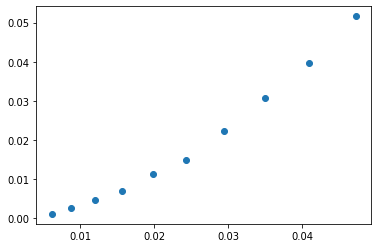

In [8]:
plt.scatter(infidelity,[max(logical['z'][j],logical['x'][j]) for j in range(len(noise))],label='max')